### The project idea is quite simple:
- Create an application that generates trend topics for a chosen subreddit.
- Your program should take as input:
    - A subreddit, for example: https://www.reddit.com/r/skincancer/
    - A start and end date
    - A number N of words for ranking
- Your program should output:
    - The top N most commented words in the period (from highest to lowest) saved in JSON format
    - An image with a word cloud for the most frequent words in the period (not necessarily the top N)


In [20]:
import praw
from fake_headers import Headers
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import nltk
from nltk.corpus import stopwords
from datetime import datetime, timedelta 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thiago_lahass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/thiago_lahass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


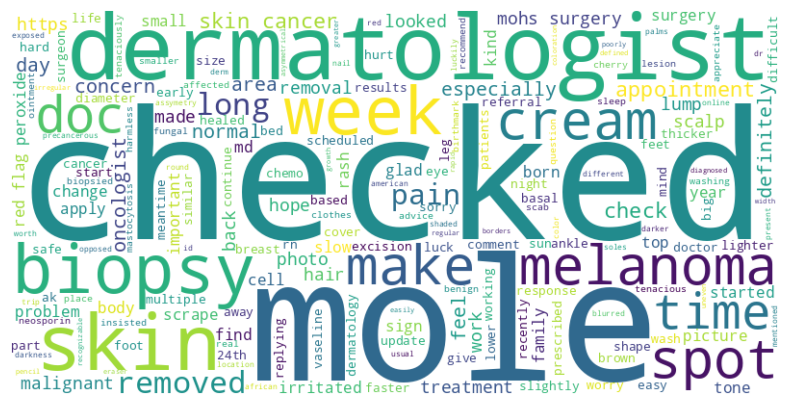

In [27]:
def get_fake_header():
    header = Headers(headers=False).generate()
    agent = header["User-Agent"]
    return agent

user_agent = get_fake_header()

# YOU NEED TO PUT YOUR CREDENTIALS HERE
reddit = praw.Reddit(client_id ='my client id', 
					client_secret ='my client secret', 
					user_agent ='my user agent', 
					username ='my username', 
					password ='my password')

nltk.download('stopwords')
nltk.download('punkt')


def clean_text(text):
    stop_words = set(stopwords.words())
    words = nltk.word_tokenize(text.lower())
    cleaned_words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(cleaned_words)

def get_comments(subreddit, start_date, end_date):
    subreddit = reddit.subreddit(subreddit)
    comments = []
    for submission in subreddit.search(query='*', time_filter='all', sort='comments', limit=None):
        if start_date <= submission.created_utc <= end_date:
            submission.comments.replace_more(limit=None)
            for comment in submission.comments.list():
                comments.append(comment.body)
    return comments

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('wordcloud.png')
    plt.show()

def generate_trend_topics(subreddit, start_date_str, end_date_str, top_n):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())
    comments = get_comments(subreddit, start_timestamp, end_timestamp)

    cleaned_comments = [clean_text(comment) for comment in comments]
    cleaned_comments = [comment for comment in cleaned_comments if comment]  # Remove comentários vazios
    if not cleaned_comments:
        print("There is no comments in the selected interval")
        return
    
    all_words = ' '.join(cleaned_comments)
    generate_wordcloud(all_words)

    words_count = nltk.FreqDist(all_words.split())
    top_words = words_count.most_common(top_n)
    top_words_json = [{'word': word, 'count': count} for word, count in top_words]
    with open('trend_topics.json', 'w') as f:
        json.dump(top_words_json, f, indent=4)

# Example
generate_trend_topics('skincancer', '2024-04-01', '2024-04-15', 10)